<a href="https://colab.research.google.com/github/LuzhiHan/lol/blob/master/ESA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install tensorflow_addons
!pip install matplotlib
!pip install pydot

别以为政治与你无关，有人送我蒙牛的产品我会以为对方要害我！
[2 2 1 ... 1 2 2]
2500
2500
Epoch 1/3
462/462 [==============================] - 427s 860ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.5691 - val_sparse_categorical_accuracy: 0.7576
Epoch 2/3
462/462 [==============================] - 394s 852ms/step - loss: 0.5118 - sparse_categorical_accuracy: 0.7907 - val_loss: 0.5343 - val_sparse_categorical_accuracy: 0.7792
Epoch 3/3
462/462 [==============================] - 397s 860ms/step - loss: 0.4458 - sparse_categorical_accuracy: 0.8182 - val_loss: 0.5107 - val_sparse_categorical_accuracy: 0.7928
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                               

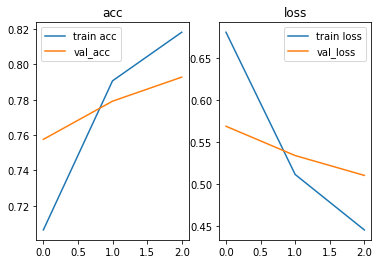

In [4]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
# os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')

# 读取数据
train_data = pd.read_csv("/cleaned_train.csv")
x_train = np.array(train_data['text'])
# x_train=np.reshape(x_train,(len(x_train),-1))
x2_train = np.array(train_data['content'])
# x2_train=np.reshape(x2_train,(len(x2_train),-1))
y_train = np.array(train_data['label'])
data = pd.read_csv("/cleaned_dev.csv")
x_data = np.array(data["text"])
x2_data = np.array(data["content"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
# x_train=np.reshape(x_train,(len(x_train),-1))
# x_dev=np.reshape(x_dev,(len(x_train),-1))
# x_train=np.reshape(x_train,(len(x_train),-1))
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train[0])
print(y_train)
print(len(x_dev))
print(len(x_test))
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=50):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

    # preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,
                             name='BERT_encoder')
    # 输入batch*seq 输出batch*seq*768
    outputs = encoder(encoder_inputs)
    # 输入batch*seq*768,输出batch*seq*512
    net = outputs['sequence_output']
    net = keras.layers.Conv1D(768, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Attention()([net, net])
    # 输入batch*seq*768,输出batch*seq*512
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.Attention()([net3, net3])

    # 输入batch*seq*768,输出batch*seq*512
    encoder_inputs2 = bert_preprocess_model(text_input2)
    encoder2 = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False, name='BERT_encoder2')
    outputs2 = encoder2(encoder_inputs2)
    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Attention()([net2, net2])
    # 输入3*batch*seq*512,输出batch*seq*1536
    net4 = keras.layers.Concatenate(axis=-1)([net, net2, net3])
    # 输入2*batch*seq*512,输出batch*seq*1024
    net5 = keras.layers.Concatenate(axis=-1)([net, net2])
    net6 = keras.layers.Concatenate(axis=-1)([net2, net3])
    net7 = keras.layers.Concatenate(axis=-1)([net, net3])
    # 输入batch*seq*1536输出batch*seq/2*64
    r1 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net)
    r1 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.2)(r1)
    r1 = keras.layers.Dense(128, activation='relu')(r1)

    r2 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net2)
    r2 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r2)
    r2 = keras.layers.MaxPooling1D(2)(r2)
    r2 = keras.layers.Flatten()(r2)
    r2 = tf.keras.layers.Dropout(0.2)(r2)
    r2 = keras.layers.Dense(128, activation='relu')(r2)

    r3 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net3)
    r3 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r3)
    r3 = keras.layers.MaxPooling1D(2)(r3)
    r3 = keras.layers.Flatten()(r3)
    r3 = tf.keras.layers.Dropout(0.2)(r3)
    r3 = keras.layers.Dense(128, activation='relu')(r3)

    r4 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net4)
    r4 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r4)
    r4 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r4)
    r4 = keras.layers.MaxPooling1D(2)(r4)
    r4 = keras.layers.Flatten()(r4)
    r4 = tf.keras.layers.Dropout(0.2)(r4)
    r4 = keras.layers.Dense(128, activation='relu')(r4)

    r5 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net5)
    r5 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r5)
    r5 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r5)
    r5 = keras.layers.MaxPooling1D(2)(r5)
    r5 = keras.layers.Flatten()(r5)
    r5 = tf.keras.layers.Dropout(0.2)(r5)
    r5 = keras.layers.Dense(128, activation='relu')(r5)

    r6 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net6)
    r6 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r6)
    r6 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r6)
    r6 = keras.layers.MaxPooling1D(2)(r6)
    r6 = keras.layers.Flatten()(r6)
    r6 = tf.keras.layers.Dropout(0.2)(r6)
    r6 = keras.layers.Dense(128, activation='relu')(r6)

    r7 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net7)
    r7 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r7)
    r7 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r7)
    r7 = keras.layers.MaxPooling1D(2)(r7)
    r7 = keras.layers.Flatten()(r7)
    r7 = tf.keras.layers.Dropout(0.2)(r7)
    r7 = keras.layers.Dense(128, activation='relu')(r7)

    r8 = outputs2['pooled_output']
    r8 = keras.layers.Dropout(0.2)(r8)
    r8 = keras.layers.Dense(64, activation='relu')(r8)

    r9 = outputs['pooled_output']
    r9 = keras.layers.Dropout(0.2)(r9)
    r9 = keras.layers.Dense(64, activation='relu')(r9)

    res = keras.layers.Concatenate(axis=-1)([r1, r2, r3, r4, r5, r6, r7, r8, r9])
    res = keras.layers.Dropout(0.2)(res)
    res = keras.layers.Dense(3, activation='softmax')(res)
    return keras.Model([text_input, text_input2], res)


model = build_classifier_model()
tf.keras.utils.plot_model(model)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-05,),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/checkpoint3/mymodel.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit([x_train, x2_train], y=y_train, epochs=3, batch_size=32,
                          validation_data=([x_dev, x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback])
model.save_weights(checkpoint_path)
model.summary()
test_loss, test_accuracy=model.evaluate(x=[x_test, x2_test],y=y_test,batch_size=32)
print(f'Loss: {test_loss}')
print(f'Accuracy: {test_accuracy}')
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()


In [15]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
# os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')

# 读取数据
train_data = pd.read_csv("/cleaned_train.csv")
x_train = np.array(train_data['text'])
# x_train=np.reshape(x_train,(len(x_train),-1))
x2_train = np.array(train_data['content'])
# x2_train=np.reshape(x2_train,(len(x2_train),-1))
y_train = np.array(train_data['label'])
data = pd.read_csv("/cleaned_dev.csv")
x_data = np.array(data["text"])
x2_data=np.array(data["content"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
x2_dev=x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test=x2_data[-2500:]
y_test = y_data[-2500:]
# x_train=np.reshape(x_train,(len(x_train),-1))
# x_dev=np.reshape(x_dev,(len(x_train),-1))
# x_train=np.reshape(x_train,(len(x_train),-1))
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train[0])
print(y_train)
print(len(x_dev))
print(len(x_test))
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=50):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

    # preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=True,
                             name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['sequence_output']
    net = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Conv1D(256, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.AveragePooling1D(pool_size=2)(net)
    net = keras.layers.Attention()([net, net])
    net = keras.layers.Flatten()(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(256, activation='relu', name='classifier')(net)

    net3 = outputs['pooled_output']
    net3 = tf.expand_dims(net3, axis=-1)
    net3 = keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid")(net3)
    print(net3.shape)
    encoder_inputs2 = bert_preprocess_model(text_input2)
    encoder2 = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder2')
    outputs2 = encoder2(encoder_inputs2)
    net2 = outputs2['pooled_output']
    net2 = tf.expand_dims(net2, axis=-1)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid"))(net2)
    print(net2.shape)
    net2 = tf.keras.layers.Dense(256, activation='relu', name='classifier4')(net2)
    net4 = keras.layers.Concatenate(axis=-1)([net, net2, net3])
    net4 = tf.keras.layers.Dropout(0.2)(net4)
    net4 = tf.keras.layers.Dense(256, activation='relu', name='classifier3')(net4)
    net4 = tf.keras.layers.Dense(3, activation='softmax', name='classifier2')(net4)
    return keras.Model([text_input, text_input2], net4)


model = build_classifier_model()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/checkpoint2/mymodel.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit([x_train, x2_train], y=y_train, epochs=1, batch_size=32, validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback])
model.save_weights(checkpoint_path)
model.summary()
with open('/weigths2.txt', 'w') as f:
    for val in model.trainable_variables:
        f.write(str(val.name) + "\n")
        f.write(str(val.shape) + '\n')
        f.write(str(val.numpy()) + '\n')
    f.close()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()


别以为政治与你无关，有人送我蒙牛的产品我会以为对方要害我！
[2 2 1 ... 1 2 2]
2500
2500
(None, 256)
(None, 512)
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_23 (Functional)          {'input_mask': (Non  0           ['text[0][0]',                   
                                e, 50),                           'text2[0][0]']                  
                                 'input_type_ids':                                                
                                (None, 50),                                                       
                                 'input_word_ids':                                                
         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ResourceExhaustedError: ignored

别以为政治与你无关，有人送我蒙牛的产品我会以为对方要害我！
[2 2 1 ... 1 2 2]
2500
2500
(None, 32, 256)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


462/462 [==============================] - 300s 601ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.7012 - val_sparse_categorical_accuracy: 0.7824
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_17 (Functional)          {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_type_ids':                                                
                                (None, 32),                                                       
                 

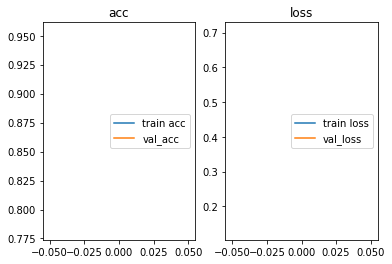

In [12]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')

#读取数据
train_data=pd.read_csv("/cleaned_train.csv")
x_train=np.array(train_data['text'])
y_train=np.array(train_data['label'])
data=pd.read_csv("/cleaned_dev.csv")
x_data=np.array(data["text"])
y_data=np.array(data["label"])
x_dev=x_data[:2500]
y_dev=y_data[:2500]
x_test=x_data[-2500:]
y_test=y_data[-2500:]
# x_train=np.reshape(x_train,(len(x_train),-1))
# x_dev=np.reshape(x_dev,(len(x_train),-1))
# x_train=np.reshape(x_train,(len(x_train),-1))
y_train=y_train.astype(np.int32)
y_dev=y_dev.astype(np.int32)
y_test=y_test.astype(np.int32)
print(x_train[0])
print(y_train)
print(len(x_dev))
print(len(x_test))
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor=hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")
def make_bert_preprocess_model(sentence_features, seq_length=32):
  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]
  bert_preprocess = preprocessor
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]
  truncated_segments = segments
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)
bert_preprocess_model = make_bert_preprocess_model(['text_input'])
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    #preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['sequence_output']
    net=keras.layers.Conv1D(512,3,activation="relu",padding="same",strides=1)(net)
    net=keras.layers.Conv1D(256,3,activation="relu",padding="same",strides=1)(net)
    #net=keras.layers.AveragePooling1D(pool_size=2)
    print(net.shape)
    net=keras.layers.Attention()([net,net])
    net=keras.layers.Flatten()(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(64, activation='relu', name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier2')(net)
    return tf.keras.Model(text_input, net)
model = build_classifier_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-05),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["sparse_categorical_accuracy"])
checkpoint_path="/checkpoint/mymodel.ckpt"
if os.path.exists(checkpoint_path+".index"):
    model.load_weights(checkpoint_path)
model_callback=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=True)
model_history=model.fit(x_train,y_train,epochs=1,batch_size=32,validation_data=(x_dev,y_dev),validation_freq=1,callbacks=[model_callback])
model.save_weights(checkpoint_path)
model.summary()
with open('/weigths.txt', 'w') as f:
    for val in model.trainable_variables:
        f.write(str(val.name) + "\n")
        f.write(str(val.shape) + '\n')
        f.write(str(val.numpy()) + '\n')
    f.close()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()


In [ ]:


from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

print("读取data.csv")
raw_train_data = load_dataset('csv', data_files='/cleaned_train.csv', split='train')
raw_test_data_set = load_dataset('csv', data_files='/cleaned_dev.csv', split='train')
data_for_dev_test = raw_test_data_set.train_test_split(test_size=0.5, train_size=0.5)
raw_dev_data = data_for_dev_test["train"]
raw_test_data = data_for_dev_test["test"]
max_length = 30


def tokenize_function(examples):
    return tokenizer(examples['text'], max_length=max_length, padding="max_length", truncation=True)


def get_encode_data(raw_data):
    tokenized_train_data = raw_data.map(tokenize_function, batched=True)
    tf_train_dataset = tokenized_train_data.with_format("tensorflow")
    train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
    encode_train_tf_dataset = train_tf_dataset.shuffle(len(train_tf_dataset)).batch(128)
    return encode_train_tf_dataset


encode_train_dataset = get_encode_data(raw_train_data)
encode_dev_dataset = get_encode_data(raw_dev_data)
encode_test_dataset = get_encode_data(raw_test_data)

from transformers import TFBertForSequenceClassification

lr = 5e-5
epoch = 5
print("加载模型")
model = TFBertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08, clipnorm=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
print("模型训练")
model.fit(encode_train_dataset, epochs=epoch, validation_data=encode_dev_dataset,validation_freq=1)
print("模型评估")
model.evaluate(encode_test_dataset)

# model.evaluate(test_data_encode)




读取data.csv


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

加载模型


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型训练
Epoch 1/5
116/116 [==============================] - 198s 1s/step - loss: 0.5967 - accuracy: 0.7561 - val_loss: 0.4841 - val_accuracy: 0.8047
Epoch 2/5
116/116 [==============================] - 169s 1s/step - loss: 0.3905 - accuracy: 0.8518 - val_loss: 0.4815 - val_accuracy: 0.8110
Epoch 3/5
116/116 [==============================] - 169s 1s/step - loss: 0.2303 - accuracy: 0.9173 - val_loss: 0.5655 - val_accuracy: 0.8117
Epoch 4/5
116/116 [==============================] - 169s 1s/step - loss: 0.1305 - accuracy: 0.9537 - val_loss: 0.6493 - val_accuracy: 0.8028
Epoch 5/5
116/116 [==============================] - 169s 1s/step - loss: 0.0911 - accuracy: 0.9690 - val_loss: 0.7341 - val_accuracy: 0.7981
模型评估
21/21 [==============================] - 10s 459ms/step - loss: 0.7151 - accuracy: 0.7959


[0.7150968313217163, 0.7958787083625793]

In [ ]:
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer
import tensorflow as tf
from matplotlib import pyplot as plt
a=transformers.models.bert.tokenization_bert
tokenizer = BertTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')
# 读取data.csv数据，并将第一列作为data,第二列作为label，数据总量14774作为训练集
print("读取data.csv")
raw_train_data = load_dataset('csv', data_files='/content/cleaned_train.csv', split='train')
raw_test_data_set = load_dataset('csv', data_files='/content/cleaned_dev.csv', split='train')
data_for_dev_test = raw_test_data_set.train_test_split(test_size=0.5, train_size=0.5)
raw_dev_data = data_for_dev_test["train"]
raw_test_data = data_for_dev_test["test"]
max_length = 64


def tokenize_function(examples):
    return tokenizer(examples['text'], max_length=max_length, padding="max_length", truncation=True,)


def get_encode_data(raw_data):
    tokenized_train_data = raw_data.map(tokenize_function, batched=True)
    tf_train_dataset = tokenized_train_data.with_format("tensorflow")
    train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
    encode_train_tf_dataset = train_tf_dataset.shuffle(len(train_tf_dataset)).batch(64)
    return encode_train_tf_dataset


encode_train_dataset = get_encode_data(raw_train_data)
encode_dev_dataset = get_encode_data(raw_dev_data)
encode_test_dataset = get_encode_data(raw_test_data)

from transformers import TFBertForSequenceClassification

lr = 5e-5
epoch = 3
print("加载模型")
model = TFBertForSequenceClassification.from_pretrained("hfl/chinese-roberta-wwm-ext", num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08, clipnorm=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
print("模型训练")
his=model.fit(encode_train_dataset, epochs=epoch, validation_data=encode_dev_dataset)
print("模型评估")
model.evaluate(encode_test_dataset)





Using custom data configuration default-51de0a2c2e222ebe


读取data.csv


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-093391fccb99a2dd


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-51de0a2c2e222ebe/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-093391fccb99a2dd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

加载模型


Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型训练
Epoch 1/3
  2/231 [..............................] - ETA: 2:37:57 - loss: 1.0884 - accuracy: 0.4062

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [ ]:
!pip install paddlepaddle-gpu

     |████████████████████████████████| 435.4 MB 31 kB/s 


In [ ]:
'''
acc=0.823
'''
import pandas as pd
import paddle
import paddlehub as hub
import ast
import argparse
from paddlehub.datasets.base_nlp_dataset import TextClassificationDataset

class MyDataset(TextClassificationDataset):
    # 数据集存放目录
    base_path = '/'
    # 数据集的标签列表，多分类标签格式为['0', '1', '2', '3',...]
    label_list = ['0', '1', '2']

    def __init__(self, tokenizer, max_seq_len: int = 128, mode: str = 'train'):
        if mode == 'train':
            data_file = 'text_label_train.tsv'
        elif mode == 'test':
            data_file = 'text_label_test.tsv'
        else:
            data_file = 'text_label_dev.tsv'
        super().__init__(
            base_path=self.base_path,
            tokenizer=tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            data_file=data_file,
            label_list=self.label_list,
            is_file_with_header=True)


if __name__ == '__main__':

    # 选择模型、任务和类别数
    model = hub.Module(name='ernie_tiny', task='seq-cls', num_classes=len(MyDataset.label_list))

    train_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=128, mode='train')
    dev_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=128, mode='dev')
    test_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=128, mode='test')

    optimizer = paddle.optimizer.Adam(learning_rate=5e-5, parameters=model.parameters())
    trainer = hub.Trainer(model, optimizer, use_gpu=True)
    trainer.train(train_dataset, epochs=3, batch_size=128, eval_dataset=dev_dataset)
    # 在测试集上评估当前训练模型
    trainer.evaluate(test_dataset, batch_size=64)


[2022-03-23 10:18:21,431] [    INFO] - Already cached /root/.paddlenlp/models/ernie-tiny/ernie_tiny.pdparams


In [ ]:
'''
acc=0.823
'''
import pandas as pd
import paddle
import paddlehub as hub
import ast
import argparse
from paddlehub.datasets.base_nlp_dataset import TextClassificationDataset

class MyDataset(TextClassificationDataset):
    # 数据集存放目录
    base_path = '/'
    # 数据集的标签列表，多分类标签格式为['0', '1', '2', '3',...]
    label_list = ['0', '1', '2']

    def __init__(self, tokenizer, max_seq_len: int = 128, mode: str = 'train'):
        if mode == 'train':
            data_file = 'text_label_train.tsv'
        elif mode == 'test':
            data_file = 'text_label_test.tsv'
        else:
            data_file = 'text_label_dev.tsv'
        super().__init__(
            base_path=self.base_path,
            tokenizer=tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            data_file=data_file,
            label_list=self.label_list,
            is_file_with_header=True)


if __name__ == '__main__':

    # 选择模型、任务和类别数
    model = hub.Module(name='bert_chinese_L-12_H-768_A-12')

    train_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=64, mode='train')
    dev_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=64, mode='dev')
    test_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=64, mode='test')

    optimizer = paddle.optimizer.Adam(learning_rate=5e-5, parameters=model.parameters())
    trainer = hub.Trainer(model, optimizer, use_gpu=True)
    trainer.train(train_dataset, epochs=3, batch_size=128, eval_dataset=dev_dataset)
    # 在测试集上评估当前训练模型
    trainer.evaluate(test_dataset, batch_size=64)


[2022-03-23 10:02:36,445] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


AttributeError: ignored

In [ ]:
!pip install paddlepaddle

     |████████████████████████████████| 108.4 MB 31 kB/s 


In [ ]:
!pip install paddlehub

     |████████████████████████████████| 212 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 2.7 MB 41.9 MB/s 
     |████████████████████████████████| 100 kB 11.0 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 12.2 MB 32.4 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 195 kB 49.1 MB/s 
     |████████████████████████████████| 127 kB 55.6 MB/s 
     |████████████████████████████████| 64 kB 2.4 MB/s 
     |████████████████████████████████| 2.1 MB 38.5 MB/s 
     |████████████████████████████████| 69 kB 8.1 MB/s 
     |████████████████████████████████| 42 kB 954 kB/s 
     |████████████████████████████████| 2.0 MB 36.5 MB/s 
     |████████████████████████████████| 8.7 MB 30.1 MB/s 
     |████████████████████████████████| 98 kB 8.7 MB/s 
     |████████████████████████████████| 461 kB 51.9 MB/s 
  Created wheel for bce-py

In [ ]:
!pip install utils

In [ ]:
import paddle
import paddle.nn.functional as F
from functools import partial
from paddlenlp.data import Stack, Tuple, Pad
from utils import convert_example, create_dataloader, evaluate
from paddlenlp.datasets import load_dataset
from paddlenlp.transformers import  ErnieGramTokenizer,  ErnieGramForSequenceClassification
from paddlenlp.transformers import LinearDecayWithWarmup

def read(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            words, labels = line.strip('\n').split('\t')
            yield {'text': words, 'label': labels}


train_ds = load_dataset(read, data_path='/train.csv', lazy=False)
dev_ds = load_dataset(read, data_path='/dev.csv', lazy=False)
test_ds = load_dataset(read, data_path='/test.csv', lazy=False)
print(len(train_ds))

tokenizer = ErnieGramTokenizer.from_pretrained('ernie-gram-zh')
model = ErnieGramForSequenceClassification.from_pretrained('ernie-gram-zh', num_classes=3)
# 模型运行批处理大小
batch_size = 64
max_seq_length = 30

trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # segment
    Stack(dtype="int64")  # label
): [data for data in fn(samples)]
train_data_loader = create_dataloader(
    dataset=train_ds.map(trans_func),
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
)
dev_data_loader = create_dataloader(
    dataset=dev_ds.map(trans_func),
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
)
test_data_loader = create_dataloader(
    dataset=test_ds.map(trans_func),
    mode='test',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
)
# 训练过程中的最大学习率
learning_rate = 5e-5
# 训练轮次
epochs = 3
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01

num_training_steps = len(train_data_loader) * epochs
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()
metric = paddle.metric.Accuracy()
global_step = 0
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        print(len(labels))
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        if global_step % 10 == 0:
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
    evaluate(model, criterion, metric, dev_data_loader)
evaluate(model, criterion, metric, test_data_loader)
model.save_pretrained('./checkpoint')
tokenizer.save_pretrained('./checkpoint')


ImportError: ignored

In [ ]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import numpy as np
import os
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import transformers
from datasets import load_dataset
import numpy as np

tf.get_logger().setLevel('ERROR')
if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
module_url = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4"
processor_url = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3"
# bert_layer = hub.KerasLayer(module_url, trainable=True)
preprocessor = hub.load(processor_url)

print("读取data.csv")
raw_train_data = load_dataset('csv', data_files='/cleaned_train.csv', split='train')
raw_test_data_set = load_dataset('csv', data_files='/cleaned_dev.csv', split='train')
data_for_dev_test = raw_test_data_set.train_test_split(test_size=0.5, train_size=0.5)
raw_dev_data = data_for_dev_test["train"]
raw_test_data = data_for_dev_test["test"]
max_length = 30

def get_encode_data(raw_data):

    tf_train_dataset = raw_data.with_format("tensorflow")
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((tf_train_dataset["text"], tf_train_dataset["label"]))
    encode_train_tf_dataset = train_tf_dataset.shuffle(len(train_tf_dataset)).batch(32)
    return encode_train_tf_dataset

x_train=raw_train_data["text"]
y_train=raw_train_data["label"]
encode_train_dataset = get_encode_data(raw_train_data)
encode_dev_dataset = get_encode_data(raw_dev_data)
encode_test_dataset = get_encode_data(raw_test_data)
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(module_url, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)
classifier_model = build_classifier_model()
classifier_model.compile(optimizer="adam",loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["sparse_categorical_accuracy"])

history = classifier_model.fit(x_train,y_train,epochs=50,batch_size=32,
                               validation_data=raw_dev_data,validation_freq=1)

读取data.csv


Epoch 1/50
261/462 [===============>..............] - ETA: 5:18 - loss: 1.2379 - sparse_categorical_accuracy: 0.3951

KeyboardInterrupt: ignored